In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
ds = pd.read_csv("trip_summary_from_df.csv")
ds.columns

Index(['pickup_day', 'pickup_hour', 'PU_Borough', 'PU_Zone', 'DO_Borough',
       'DO_Zone', 'avg_trip_miles', 'total_trips', 'avg_trip_time',
       'total_driver_pay', 'total_tips', 'total_airport_fee',
       'sum_total_congestion', 'avg_base_passenger_fare'],
      dtype='object')

In [4]:
ds.head()

,pickup_day,pickup_hour,PU_Borough,PU_Zone,DO_Borough,DO_Zone,avg_trip_miles,total_trips,avg_trip_time,total_driver_pay,total_tips,total_airport_fee,sum_total_congestion,avg_base_passenger_fare
0,Saturday,0,Brooklyn,Williamsburg (North Side),Brooklyn,Williamsburg (South Side),1.011874,246,6.595461,1825.72,98.73,6.0,0.00,12.287765
1,Saturday,0,Brooklyn,Williamsburg (South Side),Manhattan,Central Park,8.183750,4,27.470833,139.49,8.63,0.0,12.75,53.270000
2,Saturday,0,Brooklyn,Manhattan Beach,Brooklyn,Bensonhurst East,3.290933,15,10.745556,181.34,5.00,0.0,0.00,16.145334
3,Saturday,0,Brooklyn,Bath Beach,Queens,Elmhurst/Maspeth,14.780000,1,25.933332,36.58,0.00,0.0,0.00,42.010000
4,Saturday,0,Queens,Rosedale,Queens,Rosedale,1.106354,48,5.619097,281.33,7.00,0.0,0.00,9.020625


# Clustering

Clustering pickup zones into high, medium, and low demand areas?
→ Helps in targeted driver dispatch. (Service Optimization)
Since we want zones rather than individual records by day/hour, we first Aggregate to Pickup Zone Level.

Prepare Data for Clustering

1. Keep only numeric columns for clustering

2. Standardize values so high-trip-count zones don’t dominate

In [6]:
# Aggregate to Pickup Zone Level
zone_demand = ds.groupby(['PU_Borough', 'PU_Zone']).agg({
    'total_trips': 'sum',
    'total_driver_pay': 'sum',
    'avg_trip_miles': 'mean',
    'avg_trip_time': 'mean',
    'avg_base_passenger_fare': 'mean'
}).reset_index()

In [7]:
#  Use Per-Trip Averages Instead of Totals
zone_demand['driver_pay_per_trip'] = zone_demand['total_driver_pay'] / zone_demand['total_trips']

In [8]:
# Apply Weights to Strategic Features Before Scaling
zone_demand['avg_trip_miles'] *= 2        # emphasize trip length pattern
zone_demand['avg_base_passenger_fare'] *= 1.5  # emphasize fare pricing pattern

In [9]:
# Prepare Features for Clustering
features = ['total_trips', 'driver_pay_per_trip', 'avg_trip_miles', 'avg_trip_time', 'avg_base_passenger_fare']

In [10]:
# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(zone_demand[features])

In [11]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
zone_demand['demand_cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
# Label Clusters as High / Medium / Low Demand (based on total_trips)
cluster_order = zone_demand.groupby('demand_cluster')['total_trips'].mean().sort_values().index
cluster_labels = {
    cluster_order[0]: 'Low Demand',
    cluster_order[1]: 'Medium Demand',
    cluster_order[2]: 'High Demand'
}
zone_demand['demand_level'] = zone_demand['demand_cluster'].map(cluster_labels)

In [13]:
# Cluster Profile Table
cluster_profile = zone_demand.groupby('demand_level')[features].mean().round(2)
cluster_profile['zones_count'] = zone_demand.groupby('demand_level').size()
print("\nCluster Profile Table:\n", cluster_profile)


Cluster Profile Table:
                total_trips  driver_pay_per_trip  avg_trip_miles  \
demand_level                                                      
High Demand      151468.60                20.39           14.69   
Low Demand        44236.84                17.63           13.92   
Medium Demand     55746.74                18.03           18.23   

               avg_trip_time  avg_base_passenger_fare  zones_count  
demand_level                                                        
High Demand            26.65                    54.40           72  
Low Demand             22.84                    45.25          118  
Medium Demand          27.97                    54.22           68  


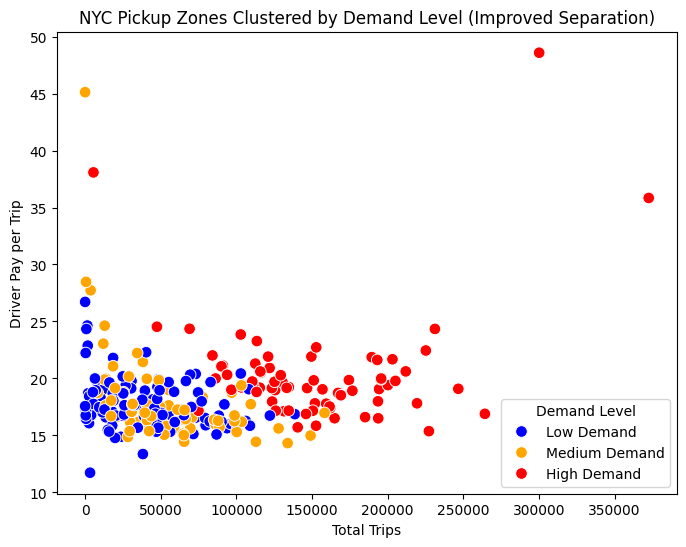

In [14]:
# Scatter Plot: Total Trips vs Driver Pay per Trip
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=zone_demand,
    x='total_trips',
    y='driver_pay_per_trip',
    hue='demand_level',
    palette={'Low Demand':'blue', 'Medium Demand':'orange', 'High Demand':'red'},
    s=70
)
plt.title("NYC Pickup Zones Clustered by Demand Level (Improved Separation)")
plt.xlabel("Total Trips")
plt.ylabel("Driver Pay per Trip")
plt.legend(title="Demand Level")
plt.show()

# Demand Clustering Summary

 Key Insights:


 1. High Demand Zones: Highest trip volume (~151k), top driver pay ($28.39), and premium fares ($54.40).

    Recommendation: Increase driver allocation during peak hours, apply surge pricing during congestion.

 2. Low Demand Zones: Lowest trips (~44k), shortest trip times (22.8 min), and lowest fares ($45.25).

    Recommendation: Promote ridership through marketing, introduce ride-pooling incentives.

 3. Medium Demand Zones: Mid-tier trips (~55k), longest trip times (27.9 min), high fare potential ($54.22).

    Recommendation: Optimize long trip routes, promote premium rides to boost profitability

#### Cluster Profie Heatmap

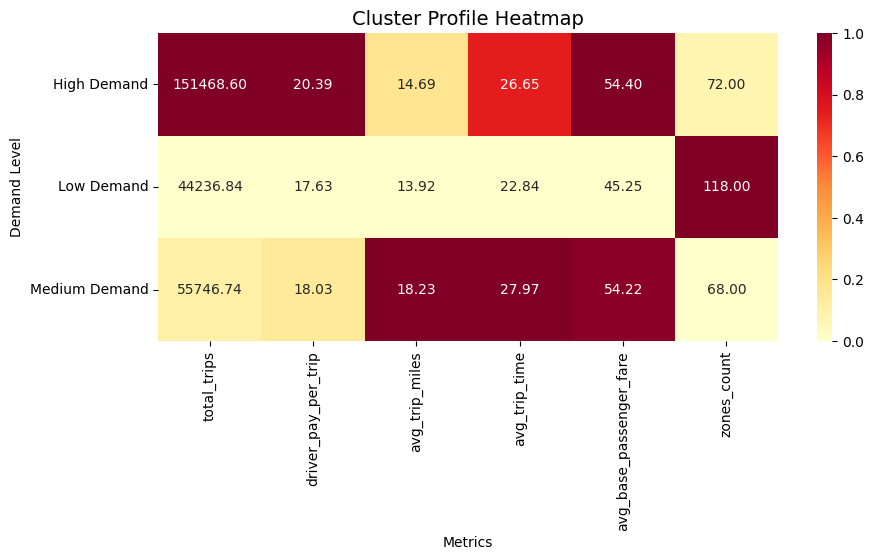

In [15]:
df_profile = cluster_profile.reset_index()

# Select only numeric columns for the heatmap
numeric_cols = df_profile.select_dtypes(include=['float64', 'int64']).columns

# Normalize values for better color contrast (min-max scaling within each column)
df_normalized = df_profile.copy()
for col in numeric_cols:
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)

# Set 'demand_level' as index again for display
df_normalized.set_index(df_profile['demand_level'], inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df_normalized[numeric_cols], annot=df_profile[numeric_cols], fmt=".2f", cmap="YlOrRd", cbar=True)
plt.title("Cluster Profile Heatmap", fontsize=14)
plt.ylabel("Demand Level")
plt.xlabel("Metrics")
plt.show()

#### To add pickup zone annotations to important points

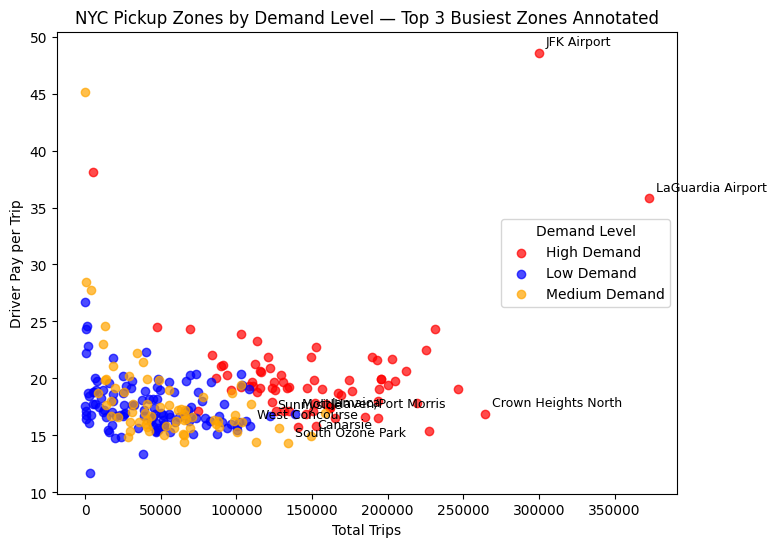

In [16]:
zone_demand['driver_pay_per_trip'] = zone_demand['total_driver_pay'] / zone_demand['total_trips']

# Pick top 3 busiest zones per demand level
top_zones = (
    zone_demand
    .sort_values("total_trips", ascending=False)
    .groupby("demand_level")
    .head(3)
)

# Color mapping for clusters (replace 'demand_level' with your cluster column name)
colors = {"Low Demand": "blue", "Medium Demand": "orange", "High Demand": "red"}

plt.figure(figsize=(8, 6))

# Plot all points
for demand_level, group in zone_demand.groupby("demand_level"):
    plt.scatter(group["total_trips"], group["driver_pay_per_trip"],
                c=colors[demand_level], label=demand_level, alpha=0.7)

# Annotate only the top 3 busiest in each demand level
for _, row in top_zones.iterrows():
    plt.annotate(row["PU_Zone"],
                 (row["total_trips"], row["driver_pay_per_trip"]),
                 textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9, color="black")

plt.xlabel("Total Trips")
plt.ylabel("Driver Pay per Trip")
plt.title("NYC Pickup Zones by Demand Level — Top 3 Busiest Zones Annotated")
plt.legend(title="Demand Level")
plt.show()

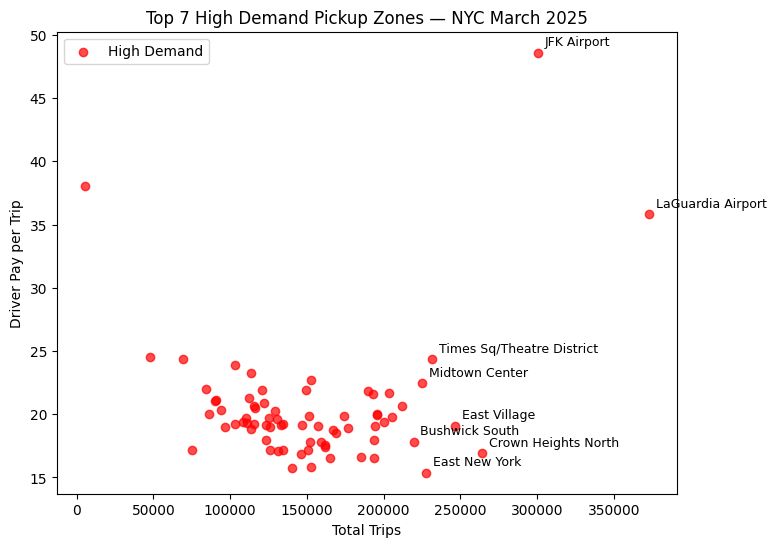

In [17]:
high_demand_zones = zone_demand[zone_demand["demand_level"] == "High Demand"].copy()

# Add per-trip driver pay
high_demand_zones["driver_pay_per_trip"] = (
    high_demand_zones["total_driver_pay"] / high_demand_zones["total_trips"]
)

# Pick top 7 busiest high demand zones
top_high = high_demand_zones.nlargest(8, "total_trips")

plt.figure(figsize=(8, 6))

# Plot all High Demand points
plt.scatter(high_demand_zones["total_trips"],
            high_demand_zones["driver_pay_per_trip"],
            c="red", alpha=0.7, label="High Demand")

# Annotate top 7
for _, row in top_high.iterrows():
    plt.annotate(row["PU_Zone"],
                 (row["total_trips"], row["driver_pay_per_trip"]),
                 textcoords="offset points", xytext=(5, 5),
                 ha='left', fontsize=9, color="black")

plt.xlabel("Total Trips")
plt.ylabel("Driver Pay per Trip")
plt.title("Top 7 High Demand Pickup Zones — NYC March 2025")
plt.legend()
plt.show()

#### Top zone table

In [18]:
def get_top_zones_per_cluster(df, n=5):
    """
    Returns top N busiest zones (by total_trips) for each demand level (cluster)
    """
    top_zones = (
        df.groupby('demand_cluster', group_keys=False)
          .apply(lambda x: x.nlargest(n, 'total_trips'))
          .reset_index(drop=True)
    )
    return top_zones

# Example usage:
top_zones_table = get_top_zones_per_cluster(zone_demand, n=5)

# Sort by cluster for easier reading
top_zones_table = top_zones_table.sort_values(by=['demand_cluster', 'total_trips'], ascending=[True, False])

import pandas as pd
pd.set_option('display.max_rows', None)  # To see all rows if needed
print(top_zones_table[['demand_cluster', 'PU_Borough', 'PU_Zone', 'total_trips']])

    demand_cluster PU_Borough                           PU_Zone  total_trips
0                0      Bronx            Mott Haven/Port Morris       138627
1                0     Queens                         Sunnyside       122150
2                0      Bronx                    West Concourse       108988
3                0  Manhattan               UN/Turtle Bay South       108170
4                0      Bronx  East Concourse/Concourse Village       106244
5                1     Queens                           Jamaica       158281
6                1   Brooklyn                          Canarsie       149063
7                1     Queens                  South Ozone Park       133901
8                1   Brooklyn                       Brownsville       127911
9                1   Brooklyn                      Borough Park       112925
10               2     Queens                 LaGuardia Airport       372568
11               2     Queens                       JFK Airport       300160